In [1]:
%matplotlib inline
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split

In [14]:
import numpy as np
import scipy
import pandas as pd
from scipy import sparse


class NotFittedException(Exception):
    pass


class WrongInputException(Exception):
    pass


class SVMClassifier:
    def __init__(self, reg_alpha=0.25,
                 rate=1,
                 max_iter=2000, 
                 min_change=1.0e-6):
        self.fitted = False
        self.w = None
        self.b = 0
        self.reg_alpha = reg_alpha
        self.rate = rate
        self.max_iter = max_iter
        self.min_change = min_change

    def fit(self, X, y, X_inv=None):
        X, y, X_inv = self.__input_data_check_transform(X, y, X_inv)
        n_samples, n_features = X.shape
        if X_inv is None:
            X_inv = self.__get_X_inv(X, y)
        self.w = np.zeros(n_features)
        errors = [np.Inf]
        for i in range(1, self.max_iter):
            rate = 1. / (self.rate * i)
            dw, db = self.__grad(X, y, X_inv)
            self.w -= rate * dw
            self.b -= rate * db
            # print(str(self.w) + ' - ' + str(self.b))
            errors.append(self.__error(X, y))
            if np.abs(errors[-1] - errors[-2]) < self.min_change:
                break
        self.fitted = True
        return errors

    def score(self, X, y):
        if not self.fitted:
            raise NotFittedException
        X, y, _ = self.__input_data_check_transform(X, y)
        predictions = self.__predict(X)
        return np.sum(predictions == y) / len(y)

    def predict(self, X):
        if not self.fitted:
            raise NotFittedException
        X, _, _ = self.__input_data_check_transform(X)
        return self.__predict(X)

    def __predict(self, X):
        return np.sign(self.__project(X))

    def __error(self, X, y):
        loc_w = self.w[:-1]
        return np.mean(self.__hinge_error(X, y)) + self.reg_alpha * np.sum(loc_w.dot(loc_w))

    def __hinge_error(self, X, y):
        return np.maximum(0, 1 - self.__project(X) * y)

    def __project(self, X):
        return X.dot(self.w) + self.b

    def __grad(self, X, y, X_inv):
        projection = self.__project(X)
        missclass = projection * y < 1
        # print('Miss ' + str(np.sum(missclass)))
        if np.sum(missclass) == 0:
            return self.reg_alpha * 2 * self.w, 0
        else:
            de = np.sum(X_inv[missclass], axis=0) / np.sum(missclass)
            de = de.A1
            return de + self.reg_alpha * 2 * self.w, -np.sign(np.sum(y[missclass]))

    def __get_X_inv(self, X, y):
        n_samples, n_features = X.shape
        X_inv = X.copy()
        for i in range(n_samples):
            X_inv[i, :] = X_inv[i, :] * -int(y[i])
        return X_inv

    def __input_data_check_transform(self, X=None, y=None, X_inv=None):
        # X data
        if X is not None:
            if isinstance(X, sparse.csr_matrix):
                pass
            elif isinstance(X, np.ndarray):
                X = sparse.csr_matrix(X)
            elif isinstance(X, np.matrix):
                X = sparse.csr_matrix(X)
            elif isinstance(X, pd.DataFrame):
                X = sparse.csr_matrix(X.as_matrix())
            else:
                raise WrongInputException
        n_samples, n_features = X.shape

        # y data
        if y is not None:
            if isinstance(y, np.ndarray):
                y = y.flatten()
            elif isinstance(y, np.matrix):
                y = y.A1
            elif isinstance(X, pd.Series):
                y = y.values
            else:
                raise WrongInputException

        if X_inv is not None  and X is not None \
                and X.shape != X_inv.shape \
                and type(X) != type(X_inv):
            X_inv = None

        return X, y, X_inv


In [3]:
# Matplotlib support
%matplotlib inline
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
def plot_svc_semi_result(a, b, c, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0] - 50, xlim[1] + 50, 30)
    ab = -a / b
    cb = -c / b
    ax.plot(x, [ab * xi + cb for xi in x])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


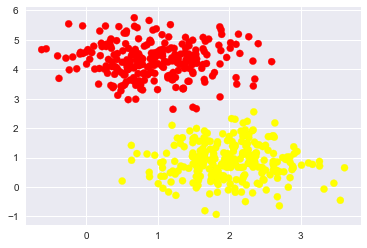

In [9]:
# Sample data
X, y = make_blobs(n_samples=500, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(type(X_train))
print(type(y_train))

In [15]:
# sklearn_model = SVC(kernel="linear", C=0.025)
sklearn_model = LinearSVC()
sklearn_model.fit(X, y)
print(sklearn_model.coef_)
print(sklearn_model.intercept_)
print(sklearn_model.score(X, y))

[[ 1.07176311 -1.42568313]]
[1.81046803]
1.0


In [16]:
my_model = SVMClassifier()
errors = my_model.fit(X, y)
print('Final model setting:')
print(my_model.w)
print(my_model.b)
print(my_model.score(X, y))

Final model setting:
[ 0.38051148 -1.12180319]
2.332584867899191
1.0


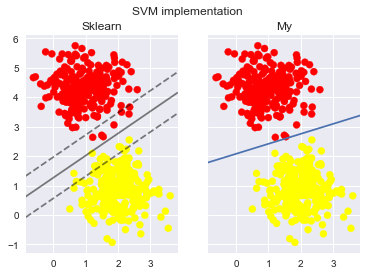

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle('SVM implementation')
ax1.set_title('Sklearn')
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(sklearn_model, ax=ax1)
ax2.set_title('My')
ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_semi_result(my_model.w[0], my_model.w[1], my_model.b, ax=ax2)

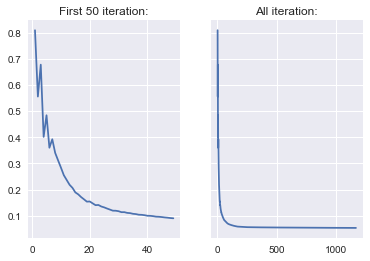

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('First 50 iteration:')
ax1.plot(range(50), errors[:50])
ax2.set_title('All iteration:')
ax2.plot(range(len(errors)), errors)